# 9.7.2 Renewable Resource Management

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 8.4.2&9.7.2

資源ストック（木材、漁業資源のようなもの）$s$のうち$x$を収穫し、それを売却し利益を得る。  
収穫コストは$c(x)$、価格は$p(x)$。  
$t+1$期のsは$s_{t+1}=h(s_{t}-x_{t})$

state variable $s\in[0,s)$  
action variable $x\in[0,s]$  
state transaction function $g(s,x)=h(s-x)$  
reward function $f(s,x)=\int_0^x p(\xi) d\xi-c(x)$  
Bellman equation $V(s)=max_{0\leq x\leq s} \{\int_0^x p(\xi) d\xi-c(x)+\delta V(h(s-x))\} $

今回の例では  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2$  
$p(x)=x^{-\gamma}$  
$f(s,x) =  \int_0^x p(\xi) d\xi-c(x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x$

In [1]:
using QuantEcon
using BasisMatrices
using Plots
using Optim

In [2]:
struct RenewableResourceManagement
    alpha::Float64
    beta::Float64
    gamma::Float64
    kappa::Float64
    delta::Float64
    s_vec::Vector{Float64}
end

In [3]:
n = 500
smin = 0
smax = 10
fspace = Basis(ChebParams(n,smin,smax))
snodes = nodes(fspace)

([2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998], Array{Float64,1}[[2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998]])

In [4]:
alpha = 4.0
beta = 1.0
gamma = 0.5
kappa = 0.2
delta = 0.9

rrm = RenewableResourceManagement(alpha,beta,gamma,kappa,delta,snodes[1])

RenewableResourceManagement(4.0, 1.0, 0.5, 0.2, 0.9, [2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998])

value function iterationを行う

In [5]:
function update_bellman(RRM::RenewableResourceManagement,V::Vector)
    a,b,g,k,d = RRM.alpha, RRM.beta, RRM.gamma, RRM.kappa, RRM.delta
    V_new = similar(V)
    policy = similar(V)
    basis = Basis(ChebParams(n, smin, smax))
    p_vec,_ = nodes(basis)
    Φ = BasisMatrix(basis, Expanded(), p_vec, 0)
    coeffs_V = Φ.vals[1] \ V
    
    for (i, s) in enumerate(RRM.s_vec)        
        objective(x) =  -((x^(1-g))/(1-g) -k*x +d*funeval(coeffs_V, basis, a*(s-x)-0.5*b*(s-x)^2))
        opt = optimize(objective,1e-10,s)
        V_new[i] = -opt.minimum
        policy[i] = opt.minimizer
    end
    return V_new,policy
end

update_bellman (generic function with 1 method)

In [6]:
V = Vector{Float64}(length(rrm.s_vec))
for i in 1:length(rrm.s_vec)
    V[i] = 6
end

In [7]:
V_comp = similar(V)
policy = similar(V)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1
while V_error > tol && i <= max_iter
    V_comp ,policy = update_bellman(rrm,V)
    V_error = maximum(abs, V_comp - V) 
    copy!(V,V_comp)
    i += 1
end


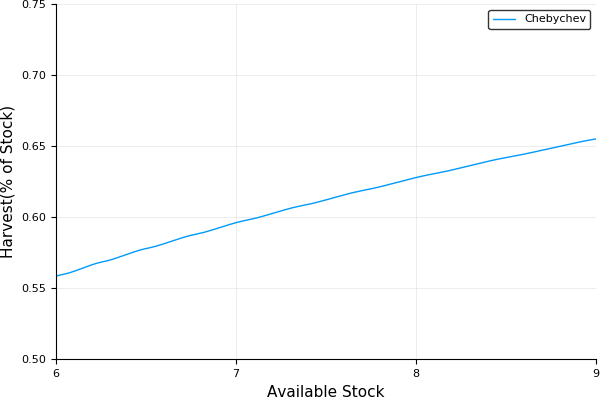

In [8]:
plot(rrm.s_vec,policy./rrm.s_vec,xlim = (6,9),ylim=(0.5,0.75),xlabel="Available Stock",ylabel="Harvest(% of Stock)",label="Chebychev")

積み残し1 なぜか少しガタガタになってる点


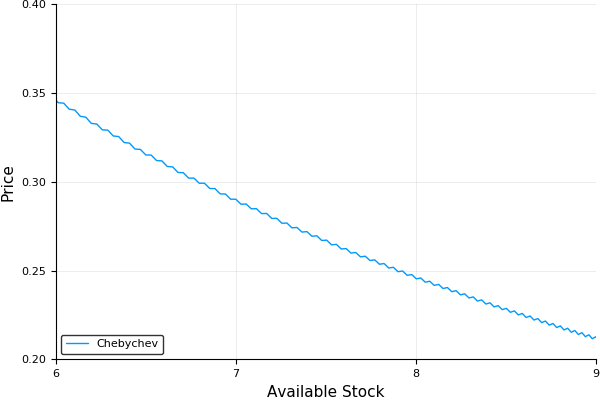

In [9]:
Phi = BasisMatrix(fspace, Expanded(), rrm.s_vec, 0)
coef = Phi.vals[1] \ V
order = 1
B1 = evalbase(fspace.params[1], rrm.s_vec, order) #Vをチェビシェフ補間したやつを一回微分
interp1 = B1 * coef
plot(rrm.s_vec, interp1, xlim = (6,9),ylim=(0.2,0.4),xlabel="Available Stock",ylabel="Price",label="Chebychev")

積み残し2 なぜかとてもガタガタになっている点（evalbaseのせい？）

In [10]:
p_func = LinInterp(rrm.s_vec, policy)
g(s,x) = 4*(s-x) - 0.5*1*(s-x)^2

years = 20
s_init = 6
s_path = Array{Float64}(years+1)
s_path[1] = s_init

for t in 2:years+1
    s_path[t] = g(s_path[t-1],p_func(s_path[t-1]))
end


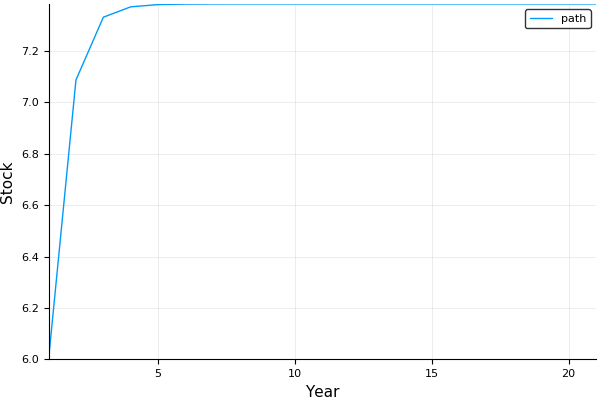

In [11]:
plot(s_path,xlabel = "Year",ylabel="Stock",label="path")

LQモデルに当てはめる

LQ  
stete vectorを$s$、control vectorを$x$、（今回は無いが）shockを$w$として、state transitionを  
\begin{eqnarray*}
s_{t+1}=As_t+Bx_t+Cw_{t+1} \\
\end{eqnarray*}
とし、目的関数  
\begin{eqnarray*}
r(s,x):=s^T_tRs_t+x^T_tQx_t+2x^T_tNs_t \\
\end{eqnarray*}
を最小化する。  

今回の例では、$r(s,x)を-f(s,x)$とし、これを最小化させる

$f(s,x)をs^*、x^*$の周りで2次までで展開すると、  
\begin{eqnarray*}
f(s,x) \simeq f(s^*,x^*)+f_s(s^*,x^*)(s-s^*)+f_x(s^*,x^*)(x-x^*)+\cfrac{1}{2}f_{ss}(s^*,x^*)(s-s^*)^2+\cfrac{1}{2}f_{xx}(s^*,x^*)(x-x^*)^2+f_{sx}(s^*,x^*)(s-s^*)(x-x^*) \\
\end{eqnarray*}

$g(s,x)をs^*、x^*$の周りで1次までで展開すると、  
\begin{eqnarray*}
g(s,x) \simeq g(s^*,x^*)+g_s(s^*,x^*)(s-s^*)+g_x(s^*,x^*)(x-x^*) \\
\end{eqnarray*}

$f^*=f(s^*,x^*)$とする  

$f(s,x) \simeq f^*+f_s^*(s-s^*)+f_x^*(x-x^*)+\cfrac{1}{2}f_{ss}^*(s-s^*)^2+\cfrac{1}{2}f_{xx}^*(x-x^*)^2+f_{sx}^*(s-s^*)(x-x^*)$  
$=\cfrac{1}{2}f_{ss}^*s^2+(f_s^*-f_{ss}^*s^*-f_{sx}x^*)s$  
$+\cfrac{1}{2}f_{xx}^*x^2+(f_x^*-f_{xx}^*x^*-f_{sx}s^*)x$  
$+f_{sx}^*sx$  
$+f^*-f_s^*s^*-f_x^*x^*+\cfrac{1}{2}f_{ss}^*s^{*2}+\cfrac{1}{2}f_{xx}^*x^{*2}+f_{sx}s^*x^*$  

$g(s,x) \simeq g(s^*,x^*)+g_s(s^*,x^*)(s-s^*)+g_x(s^*,x^*)(x-x^*)$  
$=g_s^*s+g_x^*x+g^*-g_s^*s^*-g_x^*x^*$

係数比較して、  
$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}(f_s^*-f_{ss}^*s^*-f_{sx}^*x^*) \\  -\cfrac{1}{2}(f_s^*-f_{ss}^*s^*-f_{sx}^*x^*) & -(f^*-f_s^*s^*-f_x^*x^*+\cfrac{1}{2}f_{ss}^*s^{*2}+\cfrac{1}{2}f_{xx}^*x^{*2}+f_{sx}^*s^*x^*)\end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{ss}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f_{sx}^* & -\cfrac{1}{2}(f_x^*-f_{xx}^*x^*-f_{sx}^*s^*) \end{pmatrix}$  
$A=\begin{pmatrix} g^*_s & g^*-g_s^*s^*-g_x^*x^* \\  0 & 1 \end{pmatrix}$  
$B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}$  

注 state vector は$\begin{pmatrix} s \\ 1 \end{pmatrix}$  

In [12]:
function lqapprox(f,fs,fx,fss,fxx,fsx,g,gs,gx,sstar,xstar,d)
    fstar = f(sstar,xstar)
    s = fs(sstar,xstar)
    ss = fss(sstar,xstar)
    x = fx(sstar,xstar)
    xx = fxx(sstar,xstar)
    sx = fsx(sstar,xstar)
    Q = -0.5*xx
    R = [-0.5*ss -0.5*(s-ss*sstar-sx*xstar)
            -0.5*(s-ss*sstar-sx*xstar) -(fstar-s*sstar-x*xstar+0.5*ss*sstar^2+0.5*xx*xstar^2+sx*sstar*xstar)]
    N = [-0.5*sx -0.5*(x-xx*xstar-sx*sstar)]
    A = [gs(sstar,xstar) g(sstar,xstar)-gs(sstar,xstar)*sstar-gx(sstar,xstar)*xstar
            0.0 1.0]
    B = [gx(sstar,xstar); 0]
    C = [0;0]
    lq = LQ(Q,R,A,B,C,N;bet=d)
    
    return lq
end

lqapprox (generic function with 1 method)

$y=s-x$とし、$f(s,x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x=\cfrac{(s-y)^{1-\gamma}}{1-\gamma} -\kappa (s-y)$とする。  
  
$f_{s}=(s-y)^{-\gamma}-\kappa$  
$f_{y}=-(s-y)^{-\gamma}+\kappa$  
$f_{ss}=f_{yy}=-\gamma(s-y)^{-\gamma-1}$  
$f_{sy}=\gamma(s-y)^{-\gamma-1}$  
  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2=\alpha y-0.5\beta y^2$  
$g_{s}=0$  
$g_{y}=\alpha-\beta y$

state vector は$\begin{pmatrix} s \\ 1 \end{pmatrix}$、controlは$y$

In [13]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar
f(s,y) = ((s-y)^(1-r))/(1-r) -k*(s-y)
fs(s,y) = (s-y)^(-r) -k
fy(s,y) = -(s-y)^(-r) +k
fss(s,y) = -r*(s-y)^(-1-r)
fyy(s,y) = -r*(s-y)^(-1-r)
fsy(s,y)= r*(s-y)^(-1-r)
g(s,y) = a*y - 0.5*b*y^2
gs(s,y) = 0
gy(s,y) = a - b*y

gy (generic function with 1 method)

In [14]:
lq = lqapprox(f,fs,fy,fss,fyy,fsy,g,gs,gy,sstar,ystar,d)

QuantEcon.LQ(0.0262431197105178, [0.0262431 -0.253796; -0.253796 -1.5899], [0.0 4.17284; 0.0 1.0], [1.11111, 0.0], [0, 0], [-0.0262431 0.253796], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

この後QuantEconのLectureを参考にしてやるとP,F,d = stationary_values(lq)とかやりたくなるけどstationary_valuesは変な値を返すらしい。

が、直ったらしい。（10/29）

In [15]:
P,F,d = stationary_values(lq)

([0.00262431 -0.155239; -0.155239 -31.2605], [-0.9 3.75556], 0.0)

In [16]:
V_sv(s) = [s, 1]' * P * [s, 1]

V_sv (generic function with 1 method)

In [17]:
-V_sv(sstar)

33.40964351976545

In [18]:
f(sstar,ystar)/(1-lq.bet)

33.409643519765496

In [19]:
X(s) = - (F * [s, 1])[1]

X (generic function with 1 method)

In [20]:
X(sstar)

2.8888888888889155

In [21]:
ystar

2.8888888888888884


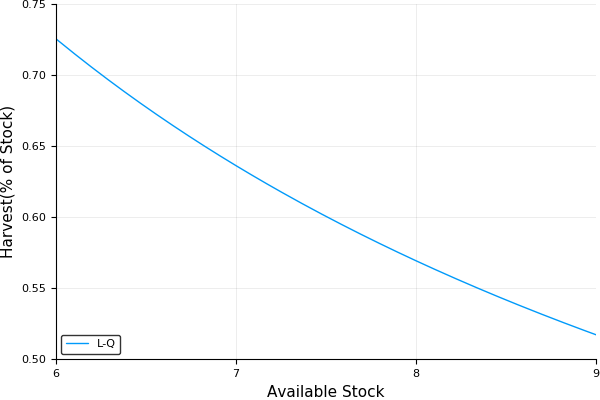

In [22]:
plot(rrm.s_vec,(rrm.s_vec.-X.(rrm.s_vec))./rrm.s_vec,xlim = (6,9),ylim=(0.5,0.75),xlabel="Available Stock",ylabel="Harvest(% of Stock)",label="L-Q")


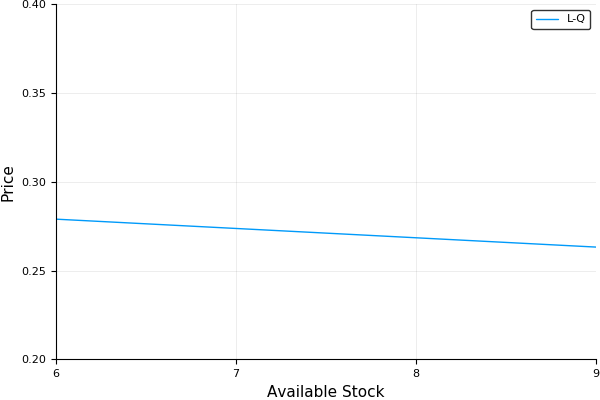

In [23]:
shadow_price(s) = -(2*P*[s, 1])[1]
plot(rrm.s_vec, shadow_price.(rrm.s_vec), xlim = (6,9),ylim=(0.2,0.4),xlabel="Available Stock",ylabel="Price",label="L-Q")

図を纏めておく


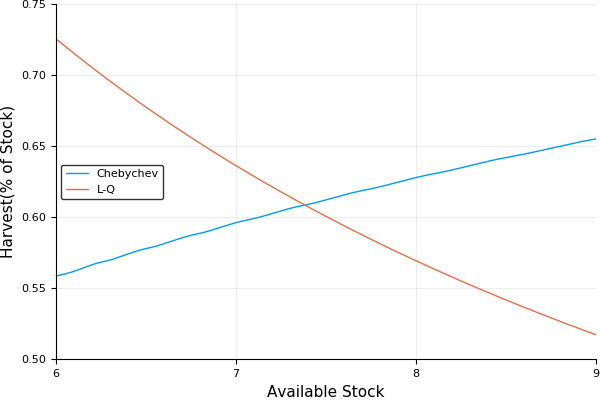

In [24]:
harvest = [policy./rrm.s_vec (rrm.s_vec.-X.(rrm.s_vec))./rrm.s_vec];
labels = ["Chebychev" "L-Q"]
plot(rrm.s_vec,harvest,xlim = (6,9),ylim=(0.5,0.75),xlabel="Available Stock",ylabel="Harvest(% of Stock)",label=labels)


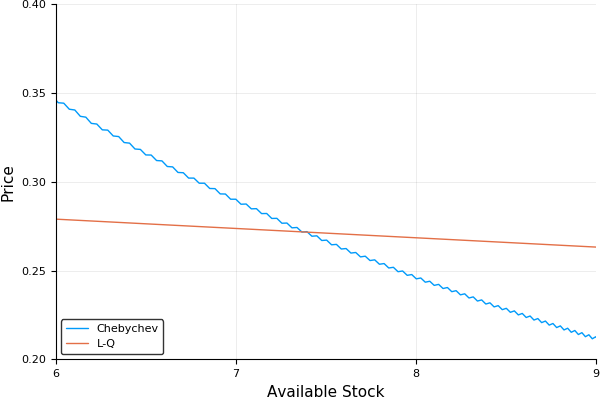

In [25]:
price = [interp1 shadow_price.(rrm.s_vec)]
plot(rrm.s_vec, price, xlim = (6,9),ylim=(0.2,0.4),xlabel="Available Stock",ylabel="Price",label=labels)

別の方法（？）

In [26]:
function riccati_rhs(P, lq)
    Q, R, A, B, N, bet = lq.Q, lq.R, lq.A, lq.B, lq.N, lq.bet
    A0, B0 = sqrt(bet) * A, sqrt(bet) * B
    out = R - (B0' * P * A0 + N)' * inv(Q + B0' * P * B0) *
        (B0' * P * A0 + N) + A0' * P * A0
    return out
end

riccati_rhs(P) = riccati_rhs(P, lq)

riccati_rhs (generic function with 2 methods)

In [27]:
function compute_F(P, lq)
    s1 = lq.Q + lq.bet * (lq.B' * P * lq.B)
    s2 = lq.bet * (lq.B' * P * lq.A) + lq.N
    F = s1 \ s2
    return F
end

compute_F (generic function with 1 method)

In [28]:
max_iter = 500
err_tol = 1e-10
P_init = lq.R
P_vi = compute_fixed_point(riccati_rhs, P_init, max_iter=max_iter,
                           verbose=2, print_skip=50, err_tol=err_tol)

Compute iterate 50 with error 0.01677890751269473
Compute iterate 100 with error 8.647352634838512e-5
Compute iterate 150 with error 4.456650835038545e-7
Compute iterate 200 with error 2.2968578150539543e-9
Converged in 230 steps


2×2 Array{Float64,2}:
  0.00262431   -0.155239
 -0.155239    -31.2605  

In [29]:
V_vi(s) = [s, 1]' * P_vi * [s, 1]

V_vi (generic function with 1 method)

In [30]:
-V_vi(sstar)

33.40964351888965

In [31]:
f(sstar,ystar)/(1-0.9)

33.409643519765496